In [2]:
%reset
import numpy as np 
import pandas as pd 
import xarray as xr 
import cartopy 
import glob
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import scipy 
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, make_union
import warnings
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.offsetbox as offsetbox
import seaborn.objects as so
from seaborn import axes_style


warnings.filterwarnings("ignore")
#from sklearn_xarray import Stacker, Select

Once deleted, variables cannot be recovered. Proceed (y/[n])? ty
Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
root_path='/data/keeling/a/rytam2/ccf_model_spread/data/preprocessed/'
kernel_path='/data/keeling/a/rytam2/a/kernels/gcms/'

In [4]:
#AMIP data
ts_amip = xr.open_mfdataset(root_path+'ts_amip_CMIP5&6_198201_200812.nc')
eis_amip = xr.open_mfdataset(root_path+'eis_amip_CMIP5&6_198201_200812.nc')
tadv_amip = xr.open_mfdataset(root_path+'tadv_amip_CMIP5&6_198201_200812.nc')*24*3600
rh_amip = xr.open_mfdataset(root_path+'hur_amip_CMIP5&6_198201_200812.nc')
omega_amip = xr.open_mfdataset(root_path+'wap_amip_CMIP5&6_198201_200812.nc')*864
ws_amip = xr.open_mfdataset(root_path+'ws_amip_CMIP5&6_198201_200812.nc')

#historical data
ts_hist = xr.open_mfdataset(root_path+'ts_obshist_CMIP5&6_2008.nc')
eis_hist = xr.open_mfdataset(root_path+'eis_obshist_CMIP5&6_2008.nc')
tadv_hist = xr.open_mfdataset(root_path+'tadv_obshist_CMIP5&6_2008.nc')*24*3600
rh_hist = xr.open_mfdataset(root_path+'hur_obshist_CMIP5&6_2008.nc')
omega_hist = xr.open_mfdataset(root_path+'wap_obshist_CMIP5&6_2008.nc')*864
ws_hist = xr.open_mfdataset(root_path+'ws_obshist_CMIP5&6_2008.nc')

#abrupt data
ts_abrupt = xr.open_mfdataset(root_path+'ts_4xCO2_CMIP5&6_Y1-150.nc') #SST 
eis_abrupt = xr.open_mfdataset(root_path+'eis_4xCO2_CMIP5&6_Y1-150.nc') #EIS 
tadv_abrupt = xr.open_mfdataset(root_path+'tadv_4xCO2_CMIP5&6_Y1-150.nc')*24*3600 #Temperature Advection 
rh_abrupt = xr.open_mfdataset(root_path+'hur_4xCO2_CMIP5&6_Y1-150.nc') # Relative Humidity 
omega_abrupt = xr.open_mfdataset(root_path+'wap_4xCO2_CMIP5&6_Y1-150.nc')*864 # Vertical advection 
ws_abrupt = xr.open_mfdataset(root_path+'ws_4xCO2_updated_CMIP5&6_Y1-150.nc') #Surface Windspeed 

# Rename Model Names 
name_list = ['CCSM4','CanESM2','CanESM5','E3SM-1-0','GFDL-CM4','HadGEM2','HadGEM3-GC31-LL','IPSL-CM6A-LR','MIROC-ES2L','MIROC-ESM',
                     'MIROC5','MIROC6','MPI-ESM','MRI-CGCM3','MRI-ESM2-0','UKESM1-0-LL']

model_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl','mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm']

rename_dict = dict(zip(sorted(name_list), sorted(model_list)))

ts_abrupt = ts_abrupt.rename(rename_dict) 
eis_abrupt = eis_abrupt.rename(rename_dict)
tadv_abrupt = tadv_abrupt.rename(rename_dict)
rh_abrupt = rh_abrupt.rename(rename_dict)
omega_abrupt = omega_abrupt.rename(rename_dict)
ws_abrupt = ws_abrupt.rename(rename_dict)

In [5]:
# Load Kernels 
kernels_list = glob.glob(kernel_path+'*.nc');

dict_sst_kernels = {}
dict_eis_kernels = {}
dict_tadv_kernels = {}
dict_rh_kernels = {}
dict_omega_kernels = {}
dict_ws_kernels = {}

modelname_list=['ccsm4','canam4','canesm5','e3sm','gfdl','hg2','hg3','ipsl',
                'mies2l','miesm','mi5','mi6','mpi','mrcgcm','mresm','ukesm'] #order must be sticktly followed to match kernels_list


# Get dRdxi from files
for filename in kernels_list:
    kernel=xr.open_mfdataset(filename)
    j = kernels_list.index(filename)
    modelname=modelname_list[j]
    dict_sst_kernels["%s"%modelname] = kernel.isel(i=0).dRdxi
    dict_eis_kernels["%s"%modelname] = kernel.isel(i=1).dRdxi
    dict_tadv_kernels["%s"%modelname] = kernel.isel(i=2).dRdxi
    dict_rh_kernels["%s"%modelname] = kernel.isel(i=3).dRdxi
    dict_omega_kernels["%s"%modelname] = kernel.isel(i=4).dRdxi
    dict_ws_kernels["%s"%modelname] = kernel.isel(i=5).dRdxi
    
# Define new coords 
coords = {'lat':(['latitude'],kernel.lat.values),
         'lon':(['longitude'],kernel.lon.values)}

# Create kernel xarray variables 
sst_kernels = xr.Dataset(data_vars=dict_sst_kernels,coords=coords);
eis_kernels = xr.Dataset(data_vars=dict_eis_kernels,coords=coords);
tadv_kernels = xr.Dataset(data_vars=dict_tadv_kernels,coords=coords);
rh_kernels = xr.Dataset(data_vars=dict_rh_kernels,coords=coords);
omega_kernels = xr.Dataset(data_vars=dict_omega_kernels,coords=coords);
ws_kernels = xr.Dataset(data_vars=dict_ws_kernels,coords=coords);

# Rename to avoid duplicate dimensions
sst_kernels = sst_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
eis_kernels = eis_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
tadv_kernels = tadv_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
rh_kernels = rh_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
omega_kernels = omega_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});
ws_kernels = ws_kernels.swap_dims(dims_dict={'latitude':'lat','longitude':'lon'});

In [6]:
# Remove seasonal cycle from measurements 
def remove_seasonality(x):
    return x - x.mean(dim='time')

#AMIP
# Group data by month and remove seasonality
ts_noseason_amip = ts_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_amip = eis_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_amip = tadv_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_amip = rh_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_amip = omega_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_amip = ws_amip.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 


#Hist
# Group data by month and remove seasonality
ts_noseason_hist = ts_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_hist = eis_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_hist = tadv_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_hist = rh_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_hist = omega_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_hist = ws_hist.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 


#Abrupt
# Group data by month and remove seasonality
ts_noseason_abrupt = ts_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
eis_noseason_abrupt = eis_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year
tadv_noseason_abrupt = tadv_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
rh_noseason_abrupt = rh_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
omega_noseason_abrupt = omega_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 
ws_noseason_abrupt = ws_abrupt.groupby('time.month').apply(remove_seasonality)#.assign_coords({'time': np.arange(1850.0,2000,1/12)}) #set decimal year 

In [7]:
# Remove seasonal cycle from measurements 
def approx_change(x,degree):
    if degree == 1: 
        poly=x.polyfit(dim='time', deg=1)
        fit = xr.polyval(x['time'],poly.polyfit_coefficients)
        change = fit.isel(time=-1)-fit.isel(time=0)
        return change
    
def normalize(x): 
    glob = x.mean('lat').mean('lon')
    norm = x/glob
    return x

def ensemble_mean(x):
    return x.to_array(dim='models').mean('models')

def make_textbox(axes, string):

    box1 = offsetbox.TextArea(string,textprops=dict(fontsize=12,ha='left',fontweight='bold'))
    anchored_box = offsetbox.AnchoredOffsetbox(loc=3,
                                 child=box1, pad=0.2,
                                 frameon=False,
                                 bbox_to_anchor=(0,1),
                                 bbox_transform=axes.transAxes,
                                 borderpad=.2)
    axes.add_artist(anchored_box)
    
    return


def shrink_width_fig1(axes):
    box = axes.get_position()
    box.x0 = box.x0 + .015
    box.x1 = box.x1 + .008
    axes.set_position(box)
    return None

def shrink_width_suppfig1(axes):
    box = axes.get_position()
    box.x0 = box.x0 + 0.098
    box.x1 = box.x1 - 0.062
    axes.set_position(box)
    return None

def shrink_width_fig2(axes):
    box = axes.get_position()
    box.x0 = box.x0 + .0125
    box.x1 = box.x1 - 0.0125
    axes.set_position(box)
    return None

def shrink_width_suppfig2(axes):
    box = axes.get_position()
    box.x0 = box.x0 + 0.11
    box.x1 = box.x1 - 0.11
    axes.set_position(box)
    return None

# Get Changes in CCF (per temperature change)

In [8]:
# Get approximated change in CCF across period 

# Get approximated change in CCF across period 

#AMIP
da_list=[approx_change(ts_noseason_amip[var],1).rename(var) for var in modelname_list]
dSST_hat_amip = xr.merge(da_list)
dT_glob_amip = ensemble_mean(dSST_hat_amip.mean('lat').mean('lon')).values
dSST_hat_amip = dSST_hat_amip/dT_glob_amip
da_list=[approx_change(eis_noseason_amip[var],1).rename(var) for var in modelname_list]
dEIS_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(tadv_noseason_amip[var],1).rename(var) for var in modelname_list]
dTadv_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(rh_noseason_amip[var],1).rename(var) for var in modelname_list]
dRH_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(omega_noseason_amip[var],1).rename(var) for var in modelname_list]
dOmega_hat_amip = xr.merge(da_list)/dT_glob_amip
da_list=[approx_change(ws_noseason_amip[var],1).rename(var) for var in modelname_list]
dWS_hat_amip = xr.merge(da_list)/dT_glob_amip

# Historical 
da_list=[approx_change(ts_noseason_hist[var],1).rename(var) for var in modelname_list]
dSST_hat_hist = xr.merge(da_list)
dT_glob_hist = ensemble_mean(dSST_hat_hist.mean('lat').mean('lon'))
dSST_hat_hist = dSST_hat_hist/dT_glob_hist
da_list=[approx_change(eis_noseason_hist[var],1).rename(var) for var in modelname_list]
dEIS_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(tadv_noseason_hist[var],1).rename(var) for var in modelname_list]
dTadv_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(rh_noseason_hist[var],1).rename(var) for var in modelname_list]
dRH_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(omega_noseason_hist[var],1).rename(var) for var in modelname_list]
dOmega_hat_hist = xr.merge(da_list)/dT_glob_hist
da_list=[approx_change(ws_noseason_hist[var],1).rename(var) for var in modelname_list]
dWS_hat_hist = xr.merge(da_list)/dT_glob_hist

# Abrupt Fast response
da_list=[approx_change(ts_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dSST_hat_fast = xr.merge(da_list)
dT_glob_fast = ensemble_mean(dSST_hat_fast.mean('lat').mean('lon'))
dSST_hat_fast = dSST_hat_fast/dT_glob_fast
da_list=[approx_change(eis_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dEIS_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(tadv_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dTadv_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(rh_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dRH_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(omega_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dOmega_hat_fast = xr.merge(da_list)/dT_glob_fast
da_list=[approx_change(ws_noseason_abrupt[var].isel(time=slice(0,239)),1).rename(var) for var in modelname_list]
dWS_hat_fast = xr.merge(da_list)/dT_glob_fast

# Abrupt Slow response
da_list=[approx_change(ts_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dSST_hat_slow = xr.merge(da_list)
dT_glob_slow = ensemble_mean(dSST_hat_slow.mean('lat').mean('lon'))
dSST_hat_slow = dSST_hat_slow/dT_glob_slow
da_list=[approx_change(eis_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dEIS_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(tadv_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dTadv_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(rh_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dRH_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(omega_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dOmega_hat_slow = xr.merge(da_list)/dT_glob_slow
da_list=[approx_change(ws_noseason_abrupt[var].isel(time=slice(240,1800)),1).rename(var) for var in modelname_list]
dWS_hat_slow = xr.merge(da_list)/dT_glob_slow

In [9]:
# Ensemble Mean Changes

# AMIP
dSST_hat_bar_amip = ensemble_mean(dSST_hat_amip)
dEIS_hat_bar_amip = ensemble_mean(dEIS_hat_amip)
dTadv_hat_bar_amip = ensemble_mean(dTadv_hat_amip)
dRH_hat_bar_amip = ensemble_mean(dRH_hat_amip)
dOmega_hat_bar_amip = ensemble_mean(dOmega_hat_amip)
dWS_hat_bar_amip = ensemble_mean(dWS_hat_amip)

# Hist
dSST_hat_bar_hist = ensemble_mean(dSST_hat_hist)
dEIS_hat_bar_hist = ensemble_mean(dEIS_hat_hist)
dTadv_hat_bar_hist = ensemble_mean(dTadv_hat_hist)
dRH_hat_bar_hist = ensemble_mean(dRH_hat_hist)
dOmega_hat_bar_hist = ensemble_mean(dOmega_hat_hist)
dWS_hat_bar_hist = ensemble_mean(dWS_hat_hist)

# Abrupt Fast response
dSST_hat_bar_fast = ensemble_mean(dSST_hat_fast)
dEIS_hat_bar_fast = ensemble_mean(dEIS_hat_fast)
dTadv_hat_bar_fast = ensemble_mean(dTadv_hat_fast)
dRH_hat_bar_fast = ensemble_mean(dRH_hat_fast)
dOmega_hat_bar_fast = ensemble_mean(dOmega_hat_fast)
dWS_hat_bar_fast = ensemble_mean(dWS_hat_fast)

# Abrupt Slow response
dSST_hat_bar_slow = ensemble_mean(dSST_hat_slow)
dEIS_hat_bar_slow = ensemble_mean(dEIS_hat_slow)
dTadv_hat_bar_slow = ensemble_mean(dTadv_hat_slow)
dRH_hat_bar_slow = ensemble_mean(dRH_hat_slow)
dOmega_hat_bar_slow = ensemble_mean(dOmega_hat_slow)
dWS_hat_bar_slow = ensemble_mean(dWS_hat_slow)

In [10]:
# Zonal Mean

# AMIP
dSST_hat_bar_amip_zonavg = dSST_hat_bar_amip.mean('lon')
dEIS_hat_bar_amip_zonavg = dEIS_hat_bar_amip.mean('lon')
dTadv_hat_bar_amip_zonavg = dTadv_hat_bar_amip.mean('lon')
dRH_hat_bar_amip_zonavg = dRH_hat_bar_amip.mean('lon')
dOmega_hat_bar_amip_zonavg = dOmega_hat_bar_amip.mean('lon')
dWS_hat_bar_amip_zonavg = dWS_hat_bar_amip.mean('lon')

# Hist
dSST_hat_bar_hist_zonavg = dSST_hat_bar_hist.mean('lon')
dEIS_hat_bar_hist_zonavg = dEIS_hat_bar_hist.mean('lon')
dTadv_hat_bar_hist_zonavg = dTadv_hat_bar_hist.mean('lon')
dRH_hat_bar_hist_zonavg = dRH_hat_bar_hist.mean('lon')
dOmega_hat_bar_hist_zonavg = dOmega_hat_bar_hist.mean('lon')
dWS_hat_bar_hist_zonavg = dWS_hat_bar_hist.mean('lon')

# Abrupt Fast response
dSST_hat_bar_fast_zonavg = dSST_hat_bar_fast.mean('lon')
dEIS_hat_bar_fast_zonavg = dEIS_hat_bar_fast.mean('lon')
dTadv_hat_bar_fast_zonavg = dTadv_hat_bar_fast.mean('lon')
dRH_hat_bar_fast_zonavg = dRH_hat_bar_fast.mean('lon')
dOmega_hat_bar_fast_zonavg = dOmega_hat_bar_fast.mean('lon')
dWS_hat_bar_fast_zonavg = dWS_hat_bar_fast.mean('lon')

# Abrupt Slow response
dSST_hat_bar_slow_zonavg = dSST_hat_bar_slow.mean('lon')
dEIS_hat_bar_slow_zonavg = dEIS_hat_bar_slow.mean('lon')
dTadv_hat_bar_slow_zonavg = dTadv_hat_bar_slow.mean('lon')
dRH_hat_bar_slow_zonavg = dRH_hat_bar_slow.mean('lon')
dOmega_hat_bar_slow_zonavg = dOmega_hat_bar_slow.mean('lon')
dWS_hat_bar_slow_zonavg = dWS_hat_bar_slow.mean('lon')

# Get Feedback Changes 

In [11]:
# AMIP
dR_SST_hat_amip = dSST_hat_amip * sst_kernels
dR_EIS_hat_amip = dEIS_hat_amip * eis_kernels
dR_Tadv_hat_amip = dTadv_hat_amip * tadv_kernels
dR_RH_hat_amip = dRH_hat_amip * rh_kernels
dR_Omega_hat_amip = dOmega_hat_amip * omega_kernels
dR_WS_hat_amip = dWS_hat_amip * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_amip_bar = ensemble_mean(dR_SST_hat_amip)
dR_EIS_hat_amip_bar = ensemble_mean(dR_EIS_hat_amip)
dR_Tadv_hat_amip_bar = ensemble_mean(dR_Tadv_hat_amip)
dR_RH_hat_amip_bar = ensemble_mean(dR_RH_hat_amip)
dR_Omega_hat_amip_bar = ensemble_mean(dR_Omega_hat_amip)
dR_WS_hat_amip_bar = ensemble_mean(dR_WS_hat_amip)


# Historical
dR_SST_hat_hist = dSST_hat_hist * sst_kernels
dR_EIS_hat_hist = dEIS_hat_hist * eis_kernels
dR_Tadv_hat_hist = dTadv_hat_hist * tadv_kernels
dR_RH_hat_hist = dRH_hat_hist * rh_kernels
dR_Omega_hat_hist = dOmega_hat_hist * omega_kernels
dR_WS_hat_hist = dWS_hat_hist * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_hist_bar = ensemble_mean(dR_SST_hat_hist)
dR_EIS_hat_hist_bar= ensemble_mean(dR_EIS_hat_hist)
dR_Tadv_hat_hist_bar = ensemble_mean(dR_Tadv_hat_hist)
dR_RH_hat_hist_bar = ensemble_mean(dR_RH_hat_hist)
dR_Omega_hat_hist_bar = ensemble_mean(dR_Omega_hat_hist)
dR_WS_hat_hist_bar = ensemble_mean(dR_WS_hat_hist)


# Abrupt fast response
dR_SST_hat_fast = dSST_hat_fast * sst_kernels
dR_EIS_hat_fast = dEIS_hat_fast * eis_kernels
dR_Tadv_hat_fast = dTadv_hat_fast * tadv_kernels
dR_RH_hat_fast = dRH_hat_fast * rh_kernels
dR_Omega_hat_fast = dOmega_hat_fast * omega_kernels
dR_WS_hat_fast = dWS_hat_fast * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_fast_bar = ensemble_mean(dR_SST_hat_fast)
dR_EIS_hat_fast_bar = ensemble_mean(dR_EIS_hat_fast)
dR_Tadv_hat_fast_bar = ensemble_mean(dR_Tadv_hat_fast)
dR_RH_hat_fast_bar = ensemble_mean(dR_RH_hat_fast)
dR_Omega_hat_fast_bar = ensemble_mean(dR_Omega_hat_fast)
dR_WS_hat_fast_bar = ensemble_mean(dR_WS_hat_fast)


# Abrupt slow response
dR_SST_hat_slow = dSST_hat_slow * sst_kernels
dR_EIS_hat_slow = dEIS_hat_slow * eis_kernels
dR_Tadv_hat_slow = dTadv_hat_slow * tadv_kernels
dR_RH_hat_slow = dRH_hat_slow * rh_kernels
dR_Omega_hat_slow = dOmega_hat_slow * omega_kernels
dR_WS_hat_slow = dWS_hat_slow * ws_kernels
# Ensemble Mean of dCCF_hat
dR_SST_hat_slow_bar = ensemble_mean(dR_SST_hat_slow)
dR_EIS_hat_slow_bar = ensemble_mean(dR_EIS_hat_slow)
dR_Tadv_hat_slow_bar = ensemble_mean(dR_Tadv_hat_slow)
dR_RH_hat_slow_bar = ensemble_mean(dR_RH_hat_slow)
dR_Omega_hat_slow_bar = ensemble_mean(dR_Omega_hat_slow)
dR_WS_hat_slow_bar = ensemble_mean(dR_WS_hat_slow)


#Total low-cloud feedback
dR_hat_amip = dR_SST_hat_amip + dR_EIS_hat_amip + dR_Tadv_hat_amip + dR_RH_hat_amip + dR_Omega_hat_amip + dR_WS_hat_amip
dR_hat_fast = dR_SST_hat_fast + dR_EIS_hat_fast + dR_Tadv_hat_fast + dR_RH_hat_fast + dR_Omega_hat_fast + dR_WS_hat_fast
dR_hat_slow = dR_SST_hat_slow + dR_EIS_hat_slow + dR_Tadv_hat_slow + dR_RH_hat_slow + dR_Omega_hat_slow + dR_WS_hat_slow
dR_hat_hist = dR_SST_hat_hist + dR_EIS_hat_hist + dR_Tadv_hat_hist + dR_RH_hat_hist + dR_Omega_hat_hist + dR_WS_hat_hist

In [12]:
# Zonal Mean Feedback

# AMIP
dR_SST_hat_amip_bar_zonavg = dR_SST_hat_amip_bar.mean('lon')
dR_EIS_hat_amip_bar_zonavg = dR_EIS_hat_amip_bar.mean('lon')
dR_Tadv_hat_amip_bar_zonavg = dR_Tadv_hat_amip_bar.mean('lon')
dR_RH_hat_amip_bar_zonavg = dR_RH_hat_amip_bar.mean('lon')
dR_Omega_hat_amip_bar_zonavg = dR_Omega_hat_amip_bar.mean('lon')
dR_WS_hat_amip_bar_zonavg = dR_WS_hat_amip_bar.mean('lon')

# Hist
dR_SST_hat_hist_bar_zonavg = dR_SST_hat_hist_bar.mean('lon')
dR_EIS_hat_hist_bar_zonavg = dR_EIS_hat_hist_bar.mean('lon')
dR_Tadv_hat_hist_bar_zonavg = dR_Tadv_hat_hist_bar.mean('lon')
dR_RH_hat_hist_bar_zonavg = dR_RH_hat_hist_bar.mean('lon')
dR_Omega_hat_hist_bar_zonavg = dR_Omega_hat_hist_bar.mean('lon')
dR_WS_hat_hist_bar_zonavg = dR_WS_hat_hist_bar.mean('lon')

# Abrupt Fast response
dR_SST_hat_fast_bar_zonavg = dR_SST_hat_fast_bar.mean('lon')
dR_EIS_hat_fast_bar_zonavg = dR_EIS_hat_fast_bar.mean('lon')
dR_Tadv_hat_fast_bar_zonavg = dR_Tadv_hat_fast_bar.mean('lon')
dR_RH_hat_fast_bar_zonavg = dR_RH_hat_fast_bar.mean('lon')
dR_Omega_hat_fast_bar_zonavg = dR_Omega_hat_fast_bar.mean('lon')
dR_WS_hat_fast_bar_zonavg = dR_WS_hat_fast_bar.mean('lon')

# Abrupt Slow response
dR_SST_hat_slow_bar_zonavg = dR_SST_hat_slow_bar.mean('lon')
dR_EIS_hat_slow_bar_zonavg = dR_EIS_hat_slow_bar.mean('lon')
dR_Tadv_hat_slow_bar_zonavg = dR_Tadv_hat_slow_bar.mean('lon')
dR_RH_hat_slow_bar_zonavg = dR_RH_hat_slow_bar.mean('lon')
dR_Omega_hat_slow_bar_zonavg = dR_Omega_hat_slow_bar.mean('lon')
dR_WS_hat_slow_bar_zonavg = dR_WS_hat_slow_bar.mean('lon')

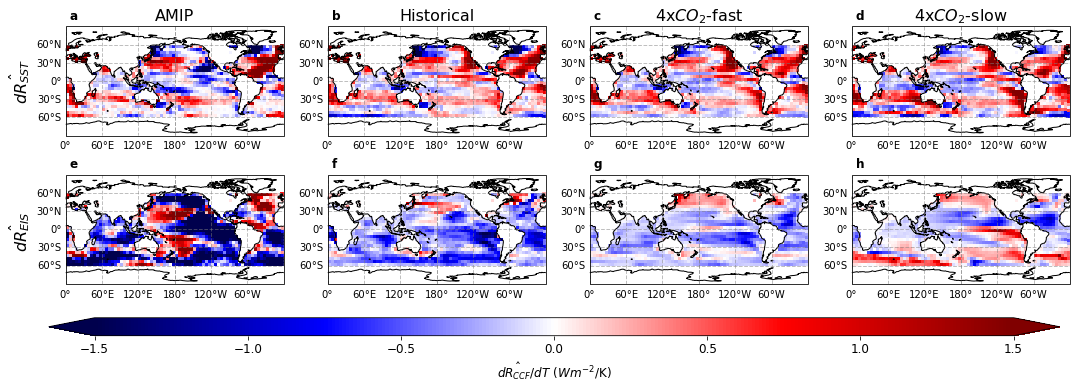

In [13]:
# Fig 2: Feedback Change of 4 CCF in 4 experiments 

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
#figcheck 
fig = plt.figure(figsize=(18,5))
ax1 = plt.subplot2grid((2,4), (0,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax2 = plt.subplot2grid((2,4), (0,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax3 = plt.subplot2grid((2,4), (0,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax4 = plt.subplot2grid((2,4), (0,3), projection=ccrs.PlateCarree(central_longitude=180.0))
ax5 = plt.subplot2grid((2,4), (1,0), projection=ccrs.PlateCarree(central_longitude=180.0))
ax6 = plt.subplot2grid((2,4), (1,1), projection=ccrs.PlateCarree(central_longitude=180.0))
ax7 = plt.subplot2grid((2,4), (1,2), projection=ccrs.PlateCarree(central_longitude=180.0))
ax8 = plt.subplot2grid((2,4), (1,3), projection=ccrs.PlateCarree(central_longitude=180.0))

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlabels_top = False
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlabels_top = False
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl3.xlabels_top = False
gl4 = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl4.xlabels_top = False
gl5 = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl5.xlabels_top = False
gl6 = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl6.xlabels_top = False
gl7 = ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl7.xlabels_top = False
gl8 = ax8.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl8.xlabels_top = False
ax1.coastlines(), ax2.coastlines(), ax3.coastlines(),ax4.coastlines(), ax5.coastlines(), ax6.coastlines(),ax7.coastlines(), ax8.coastlines()


dR_SST_hat_amip_bar.plot(ax=ax1,transform=ccrs.PlateCarree(),cmap='seismic',vmax=1.5,vmin=-1.5,add_colorbar=False)
im2 = dR_SST_hat_hist_bar.plot(ax=ax2,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False, vmax=1.5,vmin=-1.5,extend='both')
im3 = dR_SST_hat_fast_bar.plot(ax=ax3,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False,vmax=1.5,vmin=-1.5, extend='max')
im4 = dR_SST_hat_slow_bar.plot(ax=ax4,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False,vmax=1.5,vmin=-1.5,extend='both')
im1=dR_EIS_hat_amip_bar.drop('plev').plot(ax=ax5,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False,vmin=-1.5,vmax=1.5)
dR_EIS_hat_hist_bar.drop('plev').plot(ax=ax6,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False, vmax=1.5,vmin=-1.5,extend='both', )
dR_EIS_hat_fast_bar.drop('plev').plot(ax=ax7,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False,vmax=1.5,vmin=-1.5, extend='both',)
dR_EIS_hat_slow_bar.drop('plev').plot(ax=ax8,transform=ccrs.PlateCarree(),cmap='seismic',add_colorbar=False,vmax=1.5,vmin=-1.5, extend='both')


# Colorbars
cbar_ax_hist = fig.add_axes([0.112, 0.001, 0.78, 0.05])
cbar1=fig.colorbar(im2, cax=cbar_ax_hist, ticks=np.arange(-1.5,2,.5),extend='both',orientation='horizontal')
cbar1.set_label('$\hat{dR_{CCF}}/dT$ ($Wm^{-2}$/K)',size=12)
cbar1.ax.tick_params(labelsize=12);


plt.text(0.08, 0.66, '$\hat{dR_{SST}}$', fontsize=16, transform=plt.gcf().transFigure,weight='bold',rotation='vertical')
plt.text(0.08, 0.25, '$\hat{dR_{EIS}}$', fontsize=16, transform=plt.gcf().transFigure,fontweight='bold',rotation='vertical')

ax1.set_title('AMIP',fontsize=16)
ax2.set_title('Historical',fontsize=16)
ax3.set_title('4x$CO_{2}$-fast',fontsize=16)
ax4.set_title('4x$CO_{2}$-slow',fontsize=16)

make_textbox(ax1,'a')
make_textbox(ax2,'b')
make_textbox(ax3,'c')
make_textbox(ax4,'d')
make_textbox(ax5,'e')
make_textbox(ax6,'f')
make_textbox(ax7,'g')
make_textbox(ax8,'h')





plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/presentation/dR_hat_4x2_8map_allmodels_singcolorbar.png',  dpi=400, bbox_inches='tight')

# Global Feedback and Feedback per CCF spread across Models 

In [14]:
def to_dataframe(xrdataset,experiment,variable):
    globmean=xrdataset.mean('lat',skipna=True).mean('lon',skipna=True).to_array('models')
    globmodelmean=globmean.mean('models')
    df=pd.DataFrame(globmean.values, columns=['dR/dT'])
    df=df.append(pd.DataFrame([globmodelmean.values], columns=['dR/dT']))
    df.loc[:, 'models'] = modelname_list+['mean']
    df[['experiment','var']]=experiment,variable
    return df


df = to_dataframe(dR_hat_amip,'amip','Total')
df = df.append(to_dataframe(dR_hat_hist,'hist','Total'))
df = df.append(to_dataframe(dR_hat_fast,'fast','Total'))
df = df.append(to_dataframe(dR_hat_slow,'slow','Total'))
df = df.append(to_dataframe(dR_SST_hat_amip,'amip','SST'))
df = df.append(to_dataframe(dR_EIS_hat_amip,'amip','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_amip,'amip','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_amip,'amip','RH'))
df = df.append(to_dataframe(dR_Omega_hat_amip,'amip','Omega'))
df = df.append(to_dataframe(dR_WS_hat_amip,'amip','WS'))
df = df.append(to_dataframe(dR_SST_hat_hist,'hist','SST'))
df = df.append(to_dataframe(dR_EIS_hat_hist,'hist','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_hist,'hist','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_hist,'hist','RH'))
df = df.append(to_dataframe(dR_Omega_hat_hist,'hist','Omega'))
df = df.append(to_dataframe(dR_WS_hat_hist,'hist','WS'))
df = df.append(to_dataframe(dR_SST_hat_fast,'fast','SST'))
df = df.append(to_dataframe(dR_EIS_hat_fast,'fast','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_fast,'fast','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_fast,'fast','RH'))
df = df.append(to_dataframe(dR_Omega_hat_fast,'fast','Omega'))
df = df.append(to_dataframe(dR_WS_hat_fast,'fast','WS'))
df = df.append(to_dataframe(dR_SST_hat_slow,'slow','SST'))
df = df.append(to_dataframe(dR_EIS_hat_slow,'slow','EIS'))
df = df.append(to_dataframe(dR_Tadv_hat_slow,'slow','Tadv'))
df = df.append(to_dataframe(dR_RH_hat_slow,'slow','RH'))
df = df.append(to_dataframe(dR_Omega_hat_slow,'slow','Omega'))
df = df.append(to_dataframe(dR_WS_hat_slow,'slow','WS'))

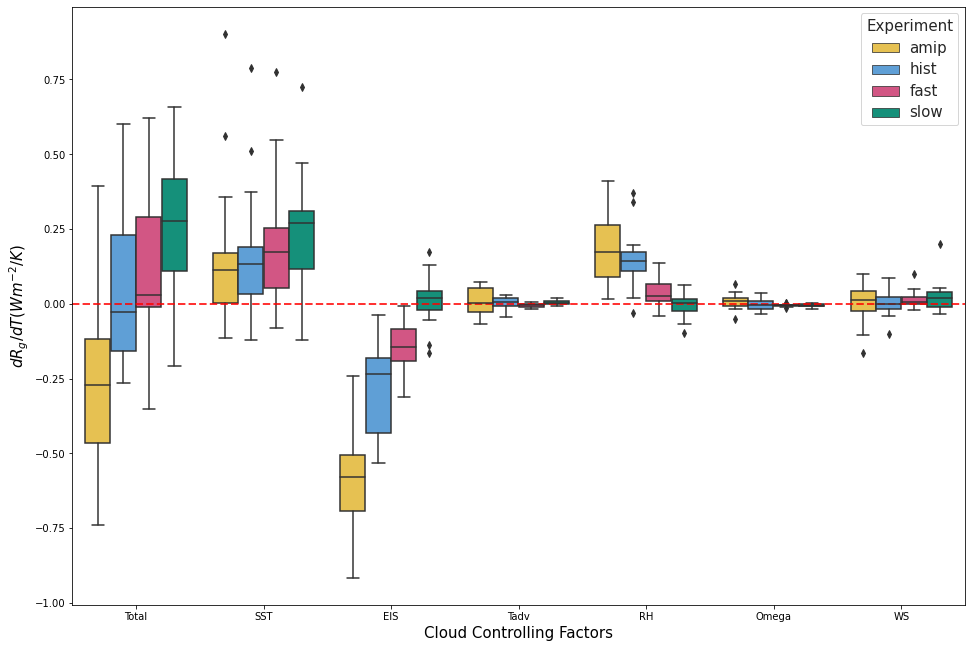

In [16]:
import seaborn.objects as so
from seaborn import axes_style
import seaborn as sns


'''p1=sns.boxplot(data=df, x="var", y="dR/dT", color="experiment")\
                  .label(color=str.capitalize,marker=str.capitalize,x='Cloud Controlling Factors', y='$dR_{g}/dT (Wm^{-2}/K)$')\
                  .layout(size=(12, 8)).scale(color=["#FFC107", "#1E88E5", "#D81B60","#004D40",'black'],pointsize=20)\
                  .theme({**axes_style("whitegrid")})\
                  .save('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/dotplot_dRg_allexperiments.png',  dpi=400, bbox_inches='tight')
'''
fig = plt.figure(figsize=(16,11))
ax1 = plt.axes()

sns.set(style = 'whitegrid',font_scale = 1.2)
graph=sns.boxplot(x ="var",
             y ="dR/dT",
             hue ="experiment",
            ax=ax1,palette=["#ffcd39", "#4ba0ea", "#e7417e","#00a488"],
             data = df_models_only)
plt.axhline(y=0,linewidth=2, color='red',alpha=0.8,linestyle='--')

plt.legend(title='Experiment')

ax1.set_xlabel('Cloud Controlling Factors', fontsize = 15)
ax1.set_ylabel('$dR_{g}/dT (Wm^{-2}/K)$', fontsize = 15)
plt.setp(graph.get_legend().get_texts(), fontsize='15')
plt.setp(graph.get_legend().get_title(), fontsize='15');

plt.savefig('/data/keeling/a/rytam2/ccf_model_spread/notebooks/figures/comp/presentation/boxplot_dRg_allmodels.png',  dpi=400, bbox_inches='tight')